<a href="https://colab.research.google.com/github/Alex6248/Analysis-of-Big-Data-in-Physics/blob/main/Week_3_ABDIP_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code of Alexandre Verheyden i6296284 for the Gravitational waves coding assignement of the Analysis of Big Data in Physics course.

In [45]:
import sys
!{sys.executable} -m pip install lalsuite==7.11 pycbc 
%pip install gwpy
%pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

In [47]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



**Problem 1: Matched filter**



First we retrieve the data and strain it to only keep relevant frequencies and time

*Before that I had to install the "certifi" package and download the file with the parameter "allow_insecure" set to True as otherwise my computer would consider it as dangerous and refuse download*

In [48]:
%pip install certifi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import astropy
astropy.utils.data.download_file('https://www.gw-openscience.org/eventapi/jsonfull/GWTC-1-confident/', cache=True, show_progress=True, timeout=None, sources=None, pkgname='astropy', http_headers=None, ssl_context=None, allow_insecure=True)

'/root/.astropy/cache/download/url/32c04293f2ab75824adf48c1893b0f97/contents'

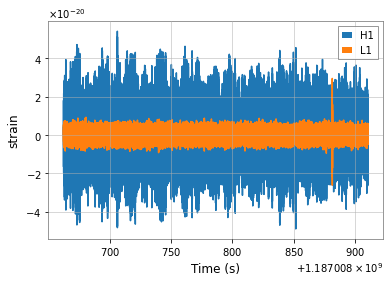

In [50]:
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass

merger= Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
   ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                   '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
  
   # Read the detector data and remove low frequency content
   strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
 
   # Remove time corrupted by the high pass filter
   strain[ifo] = strain[ifo].crop(4, 4)
  
   # Also create a frequency domain version of the data
   stilde[ifo] = strain[ifo].to_frequencyseries()
 
 
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


Now that we have our data downloaded and strained to relevant frequency values we can apply a matched filter and find the psd

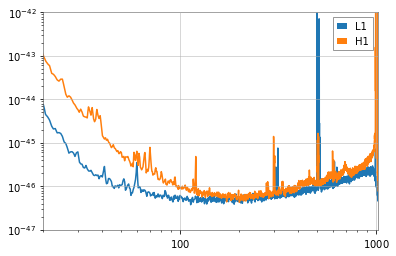

In [51]:
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)

pylab.legend()

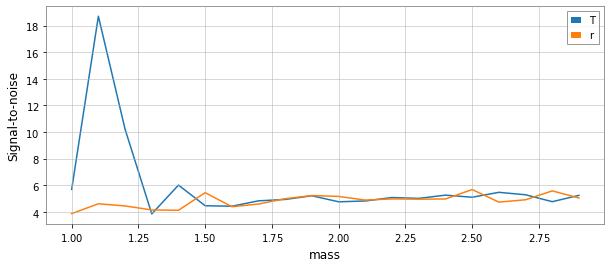

In [52]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# Defining the masses to be ranging from 1 to 3 Solar masses as indicated in the instructions
# I chose to define 
masses = mass2 = mass1 = numpy.arange(1, 3, 0.1 )

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
Snr_list = []

# Creating a loop to calculate the SNR for both Livingston and Hanford's signals
for ifo in ['H1','L1']:
  for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    m = mass1[i]
    hp, hc = get_td_waveform(approximant="TaylorT2", # choosing the 'TaylorT2' approximant as the ‘SEOBNRv4_opt' does not work
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    # Applying a matched filter from the pycbc package
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
    
    # Croping the SNR to keep only necessery uncorrupted parts
    snr_H1 = snr.crop(4 + 4, 4)

    # Adding our SNR to a list to be ploted later
    Snr_list.append(max(abs(snr_H1)))
  snrs[ifo] = Snr_list
  Snr_list = []

# Printing both SNR on one plot
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

Let's combine both signals and find for what mass is the resulting SNR maximum

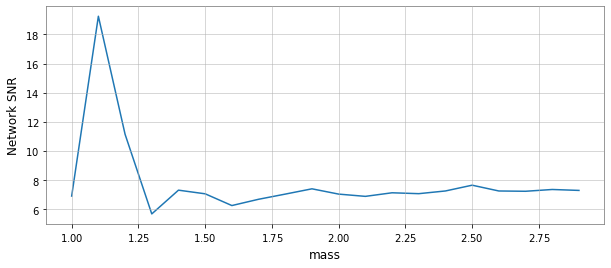

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [53]:
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5 #combines both the H1 and L1 signals
ii = np.where(nsnr == max(nsnr)) # Finds the maxima of the resulting function

# Plot the new function
pylab.figure(figsize=[10, 4]) 
pylab.plot(masses, nsnr)

pylab.ylabel('Network SNR')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

Now that we have an estimate mass we can create a template

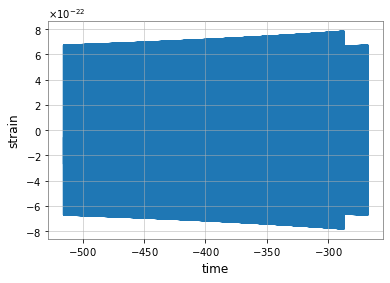

In [54]:
m = 1.10 # estimated mass in solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

Let's fit the newly created template to our data to find SNR timeseries

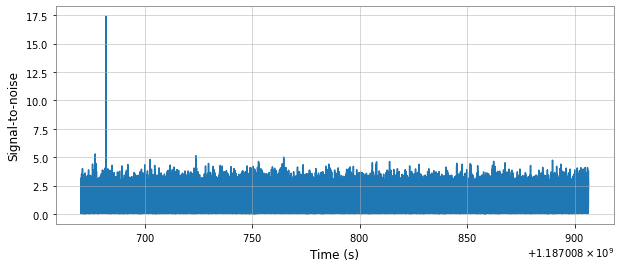

We found a signal at 1187008681.967383s with SNR 17.400042172965897


In [55]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Croping in the same way as previously
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

Now that we have our signal in the template we can perform a Q transform

We start by aligning the template to our data using time, amplitude and phase

In [56]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=15.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

We then whiten the data to transform it in terms of of our template and visualise the result

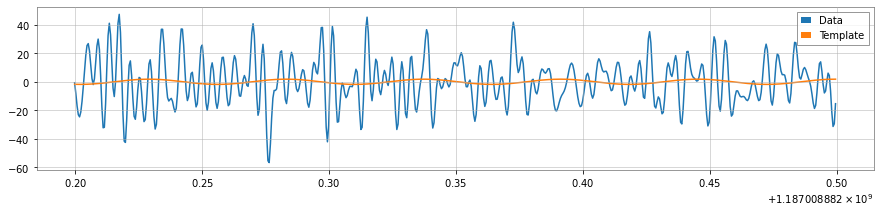

In [57]:
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(15, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(15., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(15, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

Now that both the data and template are aligned we can subtract our signal from the total noise

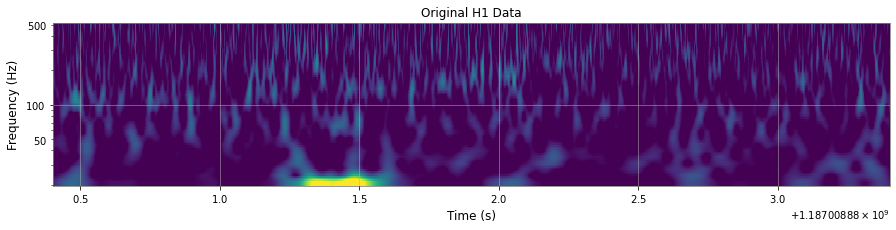

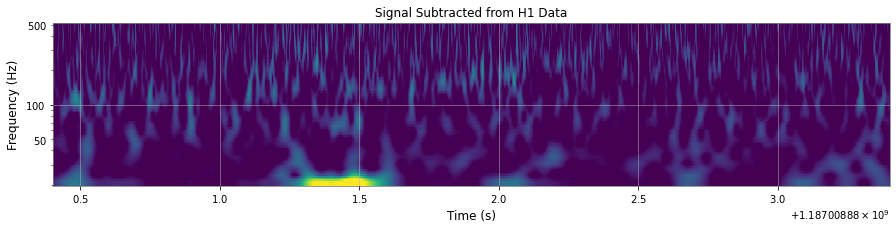

In [58]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

Finally, to conclude let's find the best match between two wave forms h* (from our data) and h_t (from the template), considering a mass interval going from 5 to 15 solar masses

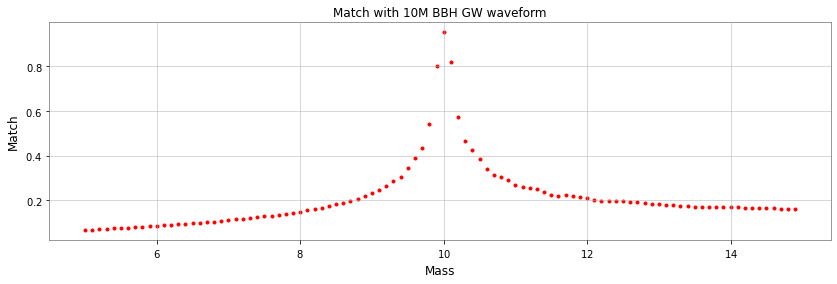

In [59]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import numpy as np

f_low = 30
sample_rate = 4096
masses = np.arange(5,15,0.1)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

**Problem 2: Detector noise**

We first download the new data and put it into Timeseries again

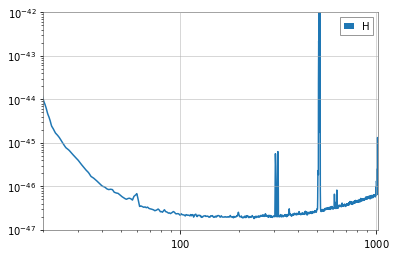

In [60]:
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy')
dt = d[:, 0]
d = TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

psds = interpolate(welch(d), 1.0 / d.duration)
  
plt.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024);
pylab.ylim(1e-47, 1e-42);
pylab.legend('H1')

Let's chek if there is any gravitational wave in this signal. To do that we look for any SNR higher than 8 in the range of 5 to 10 solar masses

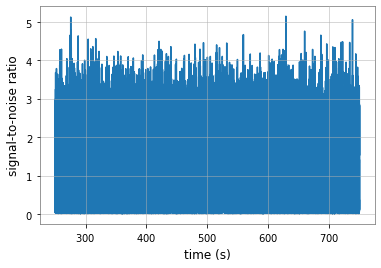

Maximum SNR 5.142557710685691


In [61]:
import numpy as np
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab

flow = 30
stilde = data.to_frequencyseries()

#Generate waveform using the 'TaylorF2' approximant for our data
hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=10, mass2=10,
                             f_lower=flow, delta_f=stilde.delta_f)
#resize it to fit our frequencyseries
hp.resize(len(stilde))  

# finds the snr
snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

#plots the snr
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) ) #finds the max snr of our data

The maximum SNR being under 8, there are no gravitational wave in this signal

We now wish to whiten the data and construct a histogram of it

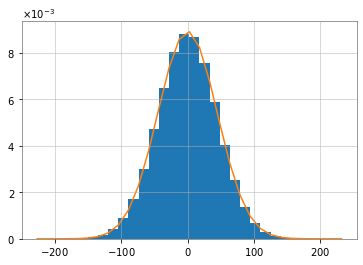

In [62]:
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)

mean = np.mean(white_data)
std = np.std(white_data)
shape = white_data.shape[0]

s = np.random.normal(mean, std, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(std * np.sqrt(2 * np.pi)) * np.exp( - (bins - mean)**2 / (2 * std**2) ))
plt.show()

The whitened data seems to indeed follow a gaussian around a zero mean

We now want to test if the stationary assumption holds

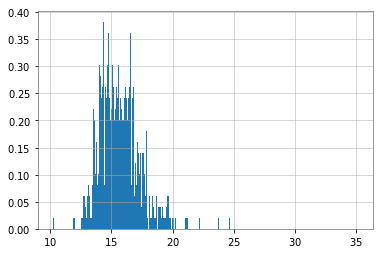

In [63]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigmasq

#we first create an arbitrary waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0)

# Slice our data in 1000 different equal time portions as suggested
slice_data= int(len(data)/1000)

# Create a loop that calulates the PSD and then SNR for each portion using the same welch method
SNRlist = []
for i in range(0,1000):
  data_chunk = data[i*slice_data:(i+1)*slice_data]

  psd = interpolate(welch(data_chunk),1.0/ d.duration)

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk),hp.delta_f)

  # We then use the 'sigmasq' function to find the optimal snr which we add to our list we will later plot
  snr_opti = (pycbc.filter.sigmasq(hp, psds))**0.5
  SNRlist.append(snr_opti)

#We then need to plot the histogram of the optimal snrs of each portions
plt.hist(SNRlist, bins = 500, density=True)
plt.show()

Our result being clearly non gaussian and not around zero, we can conclude that our assumption of a stationary gaussian does not hold